In [75]:
import torch
import torch.nn as nn
from transformers import DistilBertPreTrainedModel, DistilBertModel, AutoTokenizer, AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch.nn.functional as F


In [63]:
def get_path(base_path, file_name):
    return os.path.join(base_path, file_name)


base_path = get_path(os.getcwd(), "data")
train_path = get_path(base_path, "train.csv")
test_path = get_path(base_path, "test.csv")

##
train_df = pd.read_csv(train_path)
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [71]:
class CustomDistilBertForClassification(DistilBertPreTrainedModel):
    def __init__(self, config):
        super(CustomDistilBertForClassification, self).__init__(config)
        self.num_classes = 2
        self.distilbert = DistilBertModel(config)
        self.classification_head = nn.Linear(config.hidden_size, self.num_classes)

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.classification_head(outputs.last_hidden_state[:, 0, :])  # Assuming you want to use the [CLS] token representation

        if labels is not None:
            # Apply softmax to logits before computing cross-entropy loss
            logits = F.log_softmax(logits, dim=-1)
            loss_fct = nn.NLLLoss()  # Negative log likelihood loss for log probabilities
            loss = loss_fct(logits, labels)

            # Ensure the loss is a scalar tensor
            loss = loss.unsqueeze(0).mean()

            return {"loss": loss}

        return logits


##
model = CustomDistilBertForClassification.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


Some weights of CustomDistilBertForClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classification_head.bias', 'classification_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
train_df_ = train_df[["text", "target"]]
print(train_df_.head(1))
tokens = tokenizer(train_df_["text"].tolist(), return_tensors="pt", padding=True, truncation=True)

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1


In [66]:
text = "This is an example sentence."
input_ids = tokenizer.encode(text, add_special_tokens=True)

print("Text:", text)
print("Input IDs:", input_ids)

Text: This is an example sentence.
Input IDs: [101, 2023, 2003, 2019, 2742, 6251, 1012, 102]


In [67]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df_["text"].tolist(),
    train_df_["target"].tolist(),
    test_size=0.2,
    random_state=42
)

In [68]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, return_tensors="pt")
val_encodings = tokenizer(X_val, truncation=True, padding=True, return_tensors="pt")

# train_dataset = torch.utils.data.TensorDataset(
#     train_encodings["input_ids"],
#     train_encodings["attention_mask"],
#     torch.tensor(y_train)
# )

# val_dataset = torch.utils.data.TensorDataset(
#     val_encodings["input_ids"],
#     val_encodings["attention_mask"],
#     torch.tensor(y_val)
# )

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Example usage:
train_dataset = CustomDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train)
val_dataset = CustomDataset(val_encodings["input_ids"], val_encodings["attention_mask"], y_val)


In [72]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./distilbert-finetuned",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    evaluation_strategy="steps",
    save_total_limit=2,
    eval_steps=500,
    logging_steps=500,
    learning_rate=5e-5,
    save_steps=500,
)

# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

                                        
  0%|          | 0/2286 [04:10<?, ?it/s]          

{'loss': 0.4663, 'learning_rate': 3.906386701662293e-05, 'epoch': 0.66}

















































                                        

                                           
  0%|          | 0/2286 [04:15<?, ?it/s]          



{'eval_loss': 0.43584728240966797, 'eval_runtime': 5.2646, 'eval_samples_per_second': 289.29, 'eval_steps_per_second': 36.28, 'epoch': 0.66}


                                        
  0%|          | 0/2286 [05:43<?, ?it/s]           

{'loss': 0.3635, 'learning_rate': 2.8127734033245845e-05, 'epoch': 1.31}

















































                                        

                                           
  0%|          | 0/2286 [05:49<?, ?it/s]           



{'eval_loss': 0.4847157895565033, 'eval_runtime': 5.5334, 'eval_samples_per_second': 275.236, 'eval_steps_per_second': 34.517, 'epoch': 1.31}


                                        
  0%|          | 0/2286 [07:18<?, ?it/s]           

{'loss': 0.3092, 'learning_rate': 1.7191601049868766e-05, 'epoch': 1.97}


















































                                        

                                           
  0%|          | 0/2286 [07:23<?, ?it/s]           



{'eval_loss': 0.6416316032409668, 'eval_runtime': 5.2839, 'eval_samples_per_second': 288.233, 'eval_steps_per_second': 36.147, 'epoch': 1.97}


                                        
  0%|          | 0/2286 [08:45<?, ?it/s]           

{'loss': 0.1848, 'learning_rate': 6.255468066491689e-06, 'epoch': 2.62}




























































                                        

                                           
  0%|          | 0/2286 [08:53<?, ?it/s]           



{'eval_loss': 0.73227858543396, 'eval_runtime': 7.5986, 'eval_samples_per_second': 200.431, 'eval_steps_per_second': 25.136, 'epoch': 2.62}


                                        
100%|██████████| 2286/2286 [07:03<00:00,  5.39it/s]

{'train_runtime': 423.7543, 'train_samples_per_second': 43.115, 'train_steps_per_second': 5.395, 'train_loss': 0.3118278923935778, 'epoch': 3.0}


TrainOutput(global_step=2286, training_loss=0.3118278923935778, metrics={'train_runtime': 423.7543, 'train_samples_per_second': 43.115, 'train_steps_per_second': 5.395, 'train_loss': 0.3118278923935778, 'epoch': 3.0})

In [ ]:
print(model)

CustomDistilBertForClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
         

In [116]:
# Use Trainer.predict 
predictions = trainer.predict(val_dataset)
predictions

100%|██████████| 191/191 [00:03<00:00, 56.90it/s]


PredictionOutput(predictions=(), label_ids=array([1, 0, 1, ..., 1, 1, 0], dtype=int64), metrics={'test_loss': 0.7472735047340393, 'test_runtime': 3.3731, 'test_samples_per_second': 451.52, 'test_steps_per_second': 56.625})

# test

In [117]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs["loss"]
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_losses.append(outputs["loss"].item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}")

# Save the trained model if needed
torch.save(model.state_dict(), "custom_distilbert_classification_model.pth")

Epoch 1/3, Validation Loss: 0.5324012882386645
Epoch 2/3, Validation Loss: 0.7892291077102224
Epoch 3/3, Validation Loss: 0.753568139548103


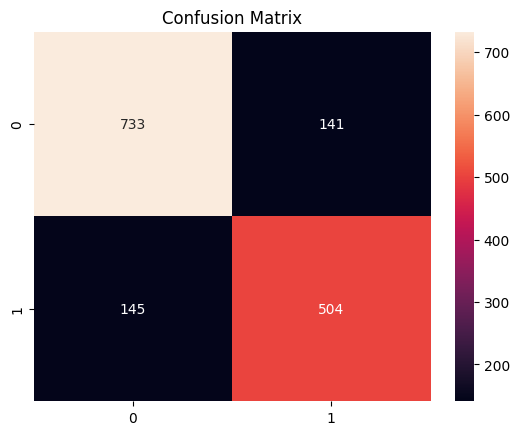

In [120]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# model_p = CustomDistilBertForClassification.from_pretrained("custom_distilbert_classification_model.pth")
model_p = model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_p.to(device)

# Load validation dataset
val_encodings = tokenizer(X_val, truncation=True, padding=True, return_tensors="pt")
val_dataset = CustomDataset(val_encodings["input_ids"], val_encodings["attention_mask"], y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Make predictions on the validation dataset
model_p.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model_p(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.squeeze()  # Assuming your logits are in the shape (batch_size, num_classes)

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch["labels"].cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")

# # Plot confusion matrix
# classes = ['Class 0', 'Class 1']  # Modify based on your actual class names
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# disp.plot(cmap=plt.cm.Blues, values_format=".4g")
plt.title("Confusion Matrix")
plt.show()

In [121]:
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.83      0.84      0.84       874
    Positive       0.78      0.78      0.78       649

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



# Check

In [79]:
# trainer.save_model("./distilbert-finetuned")

In [124]:
loaded_model = CustomDistilBertForClassification.from_pretrained('distilbert-base-uncased')
loaded_model.load_state_dict(torch.load("custom_distilbert_classification_model.pth"))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

Some weights of CustomDistilBertForClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classification_head.bias', 'classification_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomDistilBertForClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
         

# Prediction

In [80]:
checkpoint_to_load = 2000
best_model =  CustomDistilBertForClassification.from_pretrained(f"./distilbert-finetuned/checkpoint-{checkpoint_to_load}")


In [81]:
test_df = pd.read_csv(test_path)
test_df.head(1)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
